In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from haversine import haversine

In [2]:
path=r'../data/drive-me-not/processed/'
filename=r'spoofed_trace4_unique_cell.csv'
output_path=r'../outputs/png/trace4/'
data=pd.read_csv(path+filename) 
data=data[['Time','GPS_lat','GPS_long','lat','lon','spoofed']]
print(data)

               Time    GPS_lat   GPS_long        lat        lon  spoofed
0     1561285791859  25.368868  51.551123  25.369492  51.550598      0.0
1     1561285791859  25.368868  51.551123  25.367661  51.550369      0.0
2     1561285791859  25.368868  51.551123  25.368256  51.557053      0.0
3     1561285791859  25.368868  51.551123  25.366287  51.551102      0.0
4     1561285791859  25.368868  51.551123  25.368494  51.552817      0.0
...             ...        ...        ...        ...        ...      ...
5859  1561287660910  25.386922  51.446212  25.304204  51.513501      1.0
5860  1561287660910  25.386922  51.446212  25.313736  51.517776      1.0
5861  1561287660910  25.386922  51.446212  25.317307  51.520615      1.0
5862  1561287660910  25.386922  51.446212  25.317536  51.527775      1.0
5863  1561287660910  25.386922  51.446212  25.291443  51.530685      1.0

[5864 rows x 6 columns]


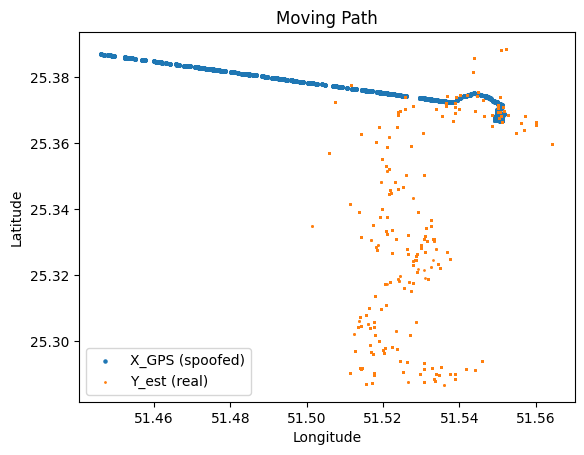

In [3]:
plt.scatter(data['GPS_long'], data['GPS_lat'],s=5,label='X_GPS (spoofed)')
plt.scatter(data['lon'], data['lat'],s=1,label='Y_est (real)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Moving Path')
plt.legend()
plt.savefig(output_path+'Garrett_moving_path')
plt.show()

In [4]:
#Garrett's first method
data['d_e']=data.apply(lambda row: haversine((row['GPS_lat'],row['GPS_long']),(row['lat'],row['lon'])), axis=1)
#Calculate the impact of different thresholds.
threadshold=np.arange(0.5,11,0.5,dtype=float)
for th in threadshold:
    name='th_'+str(th)
    data[name]=data.apply(lambda row: row['d_e']>th, axis=1)
print(data)

               Time    GPS_lat   GPS_long        lat        lon  spoofed  \
0     1561285791859  25.368868  51.551123  25.369492  51.550598      0.0   
1     1561285791859  25.368868  51.551123  25.367661  51.550369      0.0   
2     1561285791859  25.368868  51.551123  25.368256  51.557053      0.0   
3     1561285791859  25.368868  51.551123  25.366287  51.551102      0.0   
4     1561285791859  25.368868  51.551123  25.368494  51.552817      0.0   
...             ...        ...        ...        ...        ...      ...   
5859  1561287660910  25.386922  51.446212  25.304204  51.513501      1.0   
5860  1561287660910  25.386922  51.446212  25.313736  51.517776      1.0   
5861  1561287660910  25.386922  51.446212  25.317307  51.520615      1.0   
5862  1561287660910  25.386922  51.446212  25.317536  51.527775      1.0   
5863  1561287660910  25.386922  51.446212  25.291443  51.530685      1.0   

            d_e  th_0.5  th_1.0  th_1.5  ...  th_6.0  th_6.5  th_7.0  th_7.5  \
0      

In [5]:
def all_is_true(x):
    for i in x:
        if i==False:
            return False
    return True

#Calculate the impact of different bursts length.
burst_length=np.arange(1,20,1,dtype=int)
attack_start_id=np.where(data['spoofed']==1)[0][0]
attack_start_time=data['Time'][attack_start_id]

#An empty 2d data frame to store the result of FP. rows: burst_length, columns: threadshold 
fp_data=pd.DataFrame(columns=threadshold)
#An empty 2d data frame to store the result of time to detect.
detect_time_data=pd.DataFrame(columns=threadshold)

for th in threadshold:
    name='th_'+str(th)
    fp_arr=np.array([])
    detect_time_arr=np.array([])

    for bl in burst_length:
        num_fp=0
        detect_time=data['Time'][data.shape[0]-1]-attack_start_time

        for i in range(data.shape[0]-bl+1):
            if all_is_true(data[name][i:i+bl]):
                if i<=attack_start_id:
                    num_fp=num_fp+1
                else:
                    detect_time=data['Time'][i+bl-1]-attack_start_time
                    break
        fp_rate=num_fp/attack_start_id
        fp_arr=np.append(fp_arr,fp_rate)
        detect_time=detect_time/1000 #change ms to s
        detect_time_arr=np.append(detect_time_arr,detect_time)

    fp_data[th]=fp_arr
    detect_time_data[th]=detect_time_arr

print(fp_data)

        0.5       1.0       1.5       2.0       2.5       3.0       3.5   \
0   0.556439  0.334817  0.284261  0.251192  0.210175  0.152941  0.152941   
1   0.308108  0.102703  0.085215  0.072814  0.047377  0.019396  0.019396   
2   0.172019  0.015262  0.011129  0.011129  0.002226  0.001272  0.001272   
3   0.091256  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
4   0.040700  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
5   0.018124  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
6   0.006041  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
7   0.002544  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
8   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
9   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
10  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
11  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
12  0.000000

In [6]:
print(detect_time_data)

       0.5      1.0      1.5      2.0      2.5      3.0      3.5      4.0   \
0     0.000    0.000    0.000   80.502   80.502  105.257  105.257  105.257   
1     0.000    0.000   80.502   80.502  120.312  224.001  224.001  224.001   
2     0.000   55.887  132.787  157.348  172.330  224.001  250.158  266.638   
3     0.000   87.969  157.348  224.001  224.001  224.001  266.638  266.638   
4    55.887   87.969  157.348  224.001  224.001  224.001  266.638  279.625   
5    87.969  105.257  157.348  224.001  224.001  230.542  274.792  279.625   
6    87.969  157.348  157.348  224.001  224.001  230.542  274.792  279.625   
7    97.889  166.673  224.001  224.001  230.542  230.542  274.792  279.625   
8    97.889  172.653  224.001  224.001  230.542  230.542  279.625  303.744   
9    97.889  172.653  224.001  224.001  232.859  232.859  279.625  303.744   
10   97.889  224.001  224.001  224.001  232.859  232.859  279.625  322.768   
11  123.546  224.001  224.001  224.001  232.859  232.859  279.62

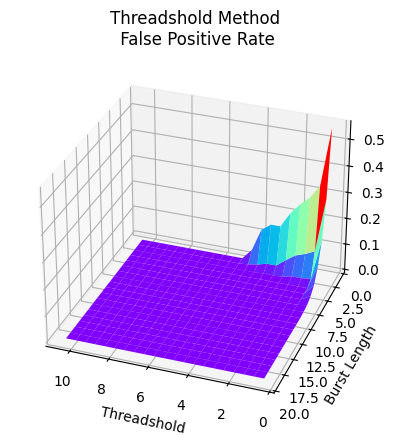

In [7]:
fig = plt.figure()
ax3 = plt.axes(projection='3d')

X, Y = np.meshgrid(threadshold, burst_length)
Z = fp_data

ax3.plot_surface(X,Y,Z,rstride = 1, cstride = 1, cmap='rainbow')
ax3.view_init(30, 110)

ax3.set_xlabel('Threadshold')
ax3.set_ylabel('Burst Length')
ax3.set_zlabel('')
plt.title('Threadshold Method\n False Positive Rate')
plt.savefig(output_path+'/Garrett_FP_rate')
plt.show()


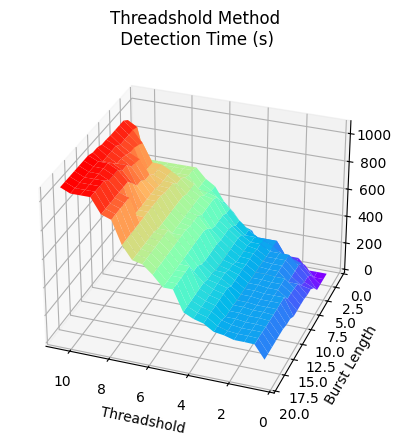

In [8]:
fig = plt.figure()
ax3 = plt.axes(projection='3d')

X, Y = np.meshgrid(threadshold, burst_length)
Z = detect_time_data

ax3.plot_surface(X,Y,Z,rstride = 1, cstride = 1, cmap='rainbow')
ax3.view_init(30,110)

ax3.set_xlabel('Threadshold')
ax3.set_ylabel('Burst Length')
ax3.set_zlabel('')
plt.title('Threadshold Method\n Detection Time (s)')
plt.savefig(output_path+'Garrett_detection_time')
plt.show()

In [9]:
def sum_larger_than_thredshold(x,th):
    s=0
    for i in x:
        s=s+i
    if s>th:
        return True
    else:
        return False

#Garrett's CUSUM method
threadshold=np.arange(5,130,5,dtype=int)
window_length=np.arange(2,100,5,dtype=int)

#An empty 2d data frame to store the result of FP. rows: window_length, columns: threadshold 
fp_data=pd.DataFrame(columns=threadshold)
#An empty 2d data frame to store the result of time to detect.
detect_time_data=pd.DataFrame(columns=threadshold)

for th in threadshold:
    name='d_e'
    fp_arr=np.array([])
    detect_time_arr=np.array([])

    for wl in window_length:
        num_fp=0
        detect_time=data['Time'][data.shape[0]-1]-attack_start_time

        for i in range(data.shape[0]-wl+1):
            if sum_larger_than_thredshold(data[name][i:i+wl],th):
                if i<=attack_start_id:
                    num_fp=num_fp+1
                else:
                    detect_time=data['Time'][i+wl-1]-attack_start_time
                    break
        fp_rate=num_fp/attack_start_id
        fp_arr=np.append(fp_arr,fp_rate)
        detect_time=detect_time/1000 #change ms to s
        detect_time_arr=np.append(detect_time_arr,detect_time)

    fp_data[th]=fp_arr
    detect_time_data[th]=detect_time_arr

print(fp_data)

         5         10        15        20        25        30        35   \
0   0.165660  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
1   0.799682  0.387917  0.091256  0.003816  0.000000  0.000000  0.000000   
2   1.000318  0.845787  0.612401  0.178378  0.009857  0.000000  0.000000   
3   1.000318  0.947536  0.838792  0.659141  0.353577  0.068045  0.005087   
4   1.000318  0.996820  0.930366  0.823847  0.700159  0.492210  0.191097   
5   1.000318  1.000318  0.958347  0.913514  0.824801  0.778060  0.575835   
6   1.000318  1.000318  0.997456  0.944992  0.895707  0.820032  0.785056   
7   1.000318  1.000318  1.000318  0.967250  0.934817  0.870588  0.818760   
8   1.000318  1.000318  1.000318  1.000318  0.952941  0.923688  0.853418   
9   1.000318  1.000318  1.000318  1.000318  0.975835  0.945946  0.914467   
10  1.000318  1.000318  1.000318  1.000318  1.000318  0.954849  0.940859   
11  1.000318  1.000318  1.000318  1.000318  1.000318  0.980604  0.951987   
12  1.000318

In [10]:
print(detect_time_data)

       5        10       15       20        25        30        35        40   \
0   80.502  296.847  622.187  638.177  1205.856  1512.662  1512.662  1512.662   
1    0.000   82.634  157.348  224.001   224.001   274.792   322.768   428.344   
2    1.022   10.129   87.969  108.376   166.673   224.001   224.001   224.001   
3    1.022    1.022   55.887   82.634   105.257   159.842   172.653   224.001   
4    1.022    1.022    1.022   80.502    82.634   105.257   123.230   160.159   
5    2.550    2.550    2.550    2.550    80.502    87.969    93.662   105.953   
6    2.550    2.550    2.550    2.550     2.550    80.502    87.969    95.006   
7   10.129   10.129   10.129   10.129    10.129    55.732    80.502    87.969   
8   10.129   10.129   10.129   10.129    10.129    10.129    55.887    82.634   
9   10.625   10.625   10.625   10.625    10.625    10.625    10.625    80.502   
10  10.625   10.625   10.625   10.625    10.625    10.625    10.625    12.987   
11  10.625   10.625   10.625

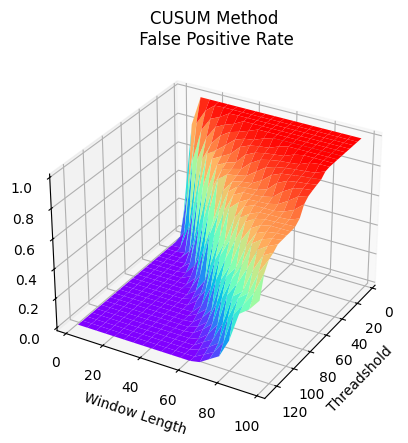

In [11]:
fig = plt.figure()
ax3 = plt.axes(projection='3d')

X, Y = np.meshgrid(threadshold, window_length)
Z = fp_data

ax3.plot_surface(X,Y,Z,rstride = 1, cstride = 1, cmap='rainbow')
ax3.view_init(30, 30)

ax3.set_xlabel('Threadshold')
ax3.set_ylabel('Window Length')
ax3.set_zlabel('')
plt.title('CUSUM Method\n False Positive Rate')
plt.savefig(output_path+'Garrett_FP_rate_CUSUM')
plt.show()

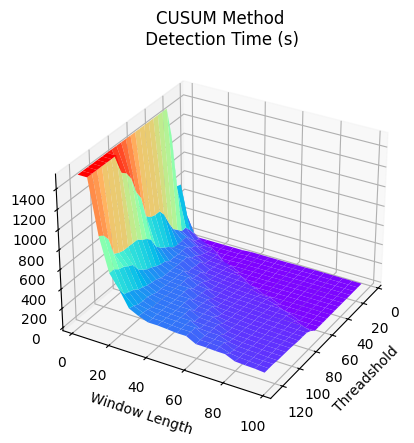

In [12]:
fig = plt.figure()
ax3 = plt.axes(projection='3d')

X, Y = np.meshgrid(threadshold, window_length)
Z = detect_time_data

ax3.plot_surface(X,Y,Z,rstride = 1, cstride = 1, cmap='rainbow')
ax3.view_init(30,30)

ax3.set_xlabel('Threadshold')
ax3.set_ylabel('Window Length')
ax3.set_zlabel('')
plt.title('CUSUM Method\n Detection Time (s)')
plt.savefig(output_path+'Garrett_detection_time_CUSUM')
plt.show()